In [1]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import math
import time
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import utils
import h5py

from mae_utils import flat_models
from mae_utils.flat import load_nsd_flat_mask, load_nsd_flat_mask_visual
from mae_utils.flat import create_nsd_flat
import mae_utils.visualize as vis

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
# following fixes a Conv3D CUDNN_NOT_SUPPORTED error
torch.backends.cudnn.benchmark = True

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
local_rank = 0 if local_rank is None else int(local_rank)
print(f"LOCAL RANK={local_rank}")

num_devices = os.getenv('NUM_GPUS')
num_devices = 1 if num_devices is None else int(num_devices)
print(f"NUM GPUS={num_devices}")
distributed = True if num_devices>1 else False
if distributed: assert device_count==num_devices

node = os.getenv('SLURM_NODEID')
node = 0 if node is None else int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
global_rank = 0 if global_rank is None else int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
world_size = 1 if world_size is None else int(world_size)
print(f"WORLD_SIZE={world_size}")

if utils.is_interactive():
    # Following allows you to change functions in other files and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Load parameters from yaml config
config = yaml.load(open('config.yaml', 'r'), Loader=yaml.FullLoader)
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']

outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)

# Override current config.yaml with that of ckpt
assert os.path.exists(f"{outdir}/config.yaml")
config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
print(f"Loaded config.yaml from ckpt folder {outdir}")

# create global variables from the config
print("\n__REPLACING_CONFIG__")
for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

data_type = torch.float32 # change depending on your mixed_precision
batch_size = os.getenv('batch_size')
batch_size = 8 if batch_size is None else int(batch_size)
global_batch_size = batch_size * world_size

model_name_suffix = os.getenv('model_name_suffix')
model_name_suffix = "" if model_name_suffix is None else (model_name_suffix+"_")

# Saving
if utils.is_interactive():
    ckpt_saving = False
else:
    ckpt_saving = True
    ckpt_interval = 999

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision
    from torch.distributed.fsdp.api import BackwardPrefetch, CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    dist.init_process_group("nccl", rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# setup wandb seed
if wandb_log and (wandb_rand==0):
    wandb_rand = str(np.random.randint(99998)+1)
    print("wandb_rand", wandb_rand)
    model_name = model_name + f"_{model_name_suffix}" + str(wandb_rand)
    print(f"New model_name is {model_name}\n")
    
# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 1
LOCAL RANK=0
NUM GPUS=1
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1
model_name = NSDflat_large_gsrFalse_40sess_9908
datasets_to_include = NSD
hcp_flat_path = /weka/proj-medarc/shared/HCP-Flat
nsd_flat_path = /weka/proj-medarc/shared/NSD-Flat
model_size = large
global_pool = False
cls_forward = False
gsr = False
use_contrastive_loss = False
use_decoder_contrastive_loss = False
cls_embed = False
decoder_cls_embed = False
use_source_embeds = False
source_embed_mode = add
source_embed_train_mode = ce
patch_size = 16
pct_masks_to_decode = 1
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
contrastive_loss_weight = 1.0
batch_size = 32
num_workers = 8
num_epochs = 100
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
test_num_samples_per_epoch = 50000
grad_clip = 1.0
grad_accumulation_steps = 1
test_set = False
plotting = True
num_sessions

## Create dataset and data loaders

In [2]:
num_sessions = os.getenv('num_sessions')
num_sessions = 40 if num_sessions is None else int(num_sessions)
print("num_sessions", num_sessions)

num_samples_per_epoch = num_sessions * 750
print("num_samples_per_epoch", num_samples_per_epoch)

flat_mask = load_nsd_flat_mask()
flat_mask_visual = load_nsd_flat_mask_visual()
num_batches = num_samples_per_epoch // (num_devices * batch_size)
print("num_batches", num_batches)

num_epochs = os.getenv('num_epochs')
num_epochs = 50 if num_epochs is None else int(num_epochs)
print("num_epochs", num_epochs)

frozenMAE = os.getenv('frozenMAE')
frozenMAE = False if frozenMAE is None else frozenMAE.lower()=="true"
print("frozenMAE", frozenMAE)

multi_subject = os.getenv('multi_subject')
multi_subject = False if multi_subject is None else multi_subject.lower()=="true"
print("multi_subject", multi_subject)

if not multi_subject:
    subj_list = [1]
else:
    subj_list = [1,2,3,4,5,6,7,8]
    subj_list.remove(1) # not pretraining on subj01
print("subj_list", subj_list)

num_sessions 40
num_samples_per_epoch 30000
num_batches 3750
num_epochs 50
frozenMAE False
multi_subject False
subj_list [1]


In [3]:
if not multi_subject:
    train_dataset = create_nsd_flat(root=nsd_flat_path, 
                    frames=num_frames, shuffle=True, sub="sub-01", num_sessions=num_sessions,
                    gsr=gsr, mindeye_only=True, only_shared1000=None)
else:
    train_dataset = create_nsd_flat(root=nsd_flat_path, 
                    frames=num_frames, shuffle=True, sub=subj_list, num_sessions=num_sessions,
                    gsr=gsr, mindeye_only=True, only_shared1000=None)

train_dl = wds.WebLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

# OLD METHOD #
# train_dl = wds.WebLoader(
#     train_dataset.batched(batch_size, partial=False),
#     batch_size=None,
#     shuffle=False,
#     num_workers=num_workers,
#     pin_memory=True,
# )
# train_dl = train_dl.with_epoch(num_batches)

Shuffle buffer size: 8428


In [4]:
shared1000_nsd_ids = np.load("shared1000_nsd_ids.npy")
shared1000_flatmaps = np.load("shared1000_flatmaps.npy")

### first instance of each unique image (1000 samples) ###
unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
group1_nsd_ids = unique_ids
group1_flatmaps = shared1000_flatmaps[indices]
print(group1_flatmaps.shape, len(group1_nsd_ids))

test_batches = [(group1_flatmaps, group1_nsd_ids)]
### ###

# ### averaging across repeats (1000 samples) ###
# unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
# group1_nsd_ids = unique_ids
# group1_flatmaps = shared1000_flatmaps[indices]
# print(group1_flatmaps.shape, len(group1_nsd_ids))

# shared1000_nsd_ids = np.delete(shared1000_nsd_ids, indices)
# unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
# group2_nsd_ids = unique_ids
# group2_flatmaps = shared1000_flatmaps[indices]
# print(group2_flatmaps.shape, len(group2_nsd_ids))

# shared1000_nsd_ids = np.delete(shared1000_nsd_ids, indices)
# unique_ids, indices = np.unique(shared1000_nsd_ids, return_index=True)
# group3_nsd_ids = unique_ids
# group3_flatmaps = shared1000_flatmaps[indices]
# print(group3_flatmaps.shape, len(group3_nsd_ids))

# assert np.array_equal(group1_nsd_ids,group2_nsd_ids) and np.array_equal(group1_nsd_ids,group3_nsd_ids)
# test_batches = [((group1_flatmaps + group2_flatmaps + group3_flatmaps)/3, group1_nsd_ids)]
# ### ###

(1000, 1, 16, 144, 320) 1000


In [5]:
### COMMENTING OUT THE CODE THAT CREATED THE ABOVE SHARED1000 NUMPY FILES ###
# test_dataset = create_nsd_flat(root=nsd_flat_path, 
#                 frames=num_frames, shuffle=False,
#                 gsr=gsr, mindeye_only=True, only_shared1000=True)
# test_dl = wds.WebLoader(
#     test_dataset.batched(3000, partial=True),
#     batch_size=None,
#     shuffle=False,
#     num_workers=1,
#     pin_memory=True,
# )
# test_batches = None
# for i, batch in enumerate(test_dl):
#     if test_batches is None:
#         test_flatmaps = batch[0]
#         test_nsd_ids = batch[2]
#         print(test_flatmaps.shape, len(test_nsd_ids))
#     else:
#         test_flatmaps = torch.vstack((test_flatmaps, batch[0]))
#         test_nsd_ids = torch.hstack((test_nsd_ids, batch[2]))
#         print(test_flatmaps.shape, len(test_nsd_ids))
# np.save("shared1000_nsd_ids", test_nsd_ids.numpy())
# np.save("shared1000_flatmaps", test_flatmaps.numpy())

## Create & load model

In [6]:
assert model_size in {"huge", "large", "small"}, "undefined model_size"

if model_size=="huge":
    model = flat_models.mae_vit_huge_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="large":
    model = flat_models.mae_vit_large_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="small":
    model = flat_models.mae_vit_small_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
utils.count_params(model)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
param counts:
316,392,704 total
316,392,704 trainable


316392704

In [7]:
checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]

latest_checkpoint = "epoch199.pth"
checkpoint_path = os.path.join(outdir, latest_checkpoint)
if not os.path.exists(checkpoint_path):
    latest_checkpoint = "epoch99.pth"
    checkpoint_path = os.path.join(outdir, latest_checkpoint)
print(f"latest_checkpoint: {checkpoint_path}")

state = torch.load(checkpoint_path)
model.load_state_dict(state["model_state_dict"], strict=False)

print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}\n")

# print("===\nNOT LOADING ANY PRETRAINED MODEL\n===")

===
NOT LOADING ANY PRETRAINED MODEL
===


In [8]:
print("change mask to visual cortex only")
model.initialize_mask(flat_mask_visual)

change mask to visual cortex only


### Check data loaders work

Yielding 2 batches


0it [00:00, ?it/s]

iter 0
input_func torch.Size([8, 1, 16, 144, 320])


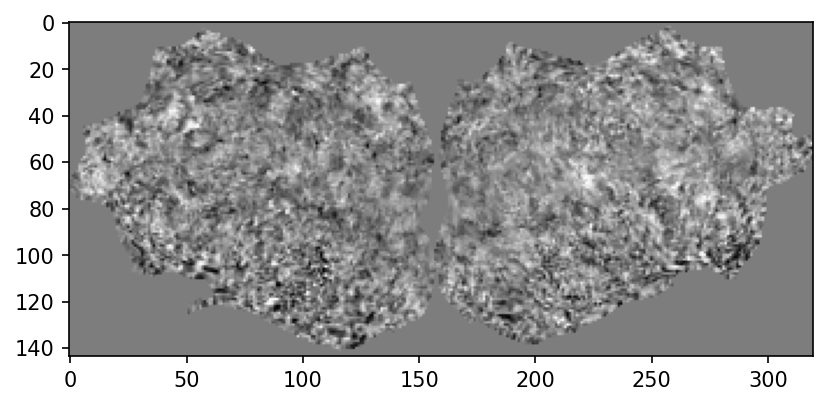

1it [00:02,  2.84s/it]

iter 1
input_func torch.Size([8, 1, 16, 144, 320])


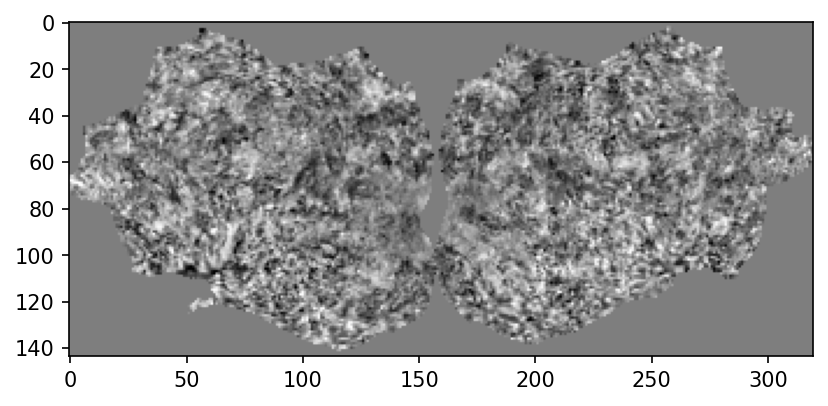

2it [00:03,  1.58s/it]

Execution time: 3.1581413745880127 seconds


In [9]:
if utils.is_interactive():   
    start_time = time.time() 
    num_it = 2 #425 #468
    print(f"Yielding {num_it} batches")
    
    for i, batch in enumerate(tqdm(train_dl)):#, total=num_batches)):
        input_func = batch[0]

        if len(batch[1])!=batch_size:
            print(len(batch[1]))
            continue
        if len(np.unique(np.array(batch[1]))) != len(np.array(batch[1])):
            print(len(np.unique(np.array(batch[1]))), len(np.array(batch[1])))
        
        if i >= num_it:
            break

        # for b in batch[1]:
        #     if int(str(b)[:2]) > 40:
        #         error
        #     tracker[str(b)[:2]] = tracker.get(str(b)[:2], 0) + 1

        print("iter",i)
        print("input_func", input_func.shape)
            
        plt.imshow(input_func[0,0,0], cmap='gray')
        plt.show()

    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

In [10]:
# Load 73k NSD images
data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu")

In [11]:
sys.path.append('mindeye_utils/')
import mindeye_utils.generative_models.sgm
from mindeye_utils.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from mindeye_utils.generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

try:
    print(clip_img_embedder)
except:
    # # last hidden
    # clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    #     arch="ViT-bigG-14",
    #     version="laion2b_s39b_b160k",
    #     output_tokens=True,
    #     only_tokens=True,
    # )
    # clip_img_embedder.to(device)
    # clip_seq_dim = 256
    # clip_emb_dim = 1664

    # final
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=False,
        only_tokens=False,
    )
    clip_img_embedder.to(device)
    clip_seq_dim = 1
    clip_emb_dim = 1280

/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/admin/home-paulscotti/foundation_env/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

In [12]:
hidden_dim=1024
n_blocks=4
clip_scale=1

if frozenMAE: model.requires_grad_(False)

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out

if global_pool and cls_forward:
    print("You specified using both global_pooling AND the cls token as the input to MindEye2.\nThis defaults to cls token, not global pooling.")
if global_pool or cls_forward:
    model.ridge = RidgeRegression([model.embed_dim] * len(subj_list), out_features=hidden_dim)
else:
    if use_source_embeds:
        model.ridge = RidgeRegression([290 * model.embed_dim] * len(subj_list), out_features=hidden_dim)
    elif cls_embed:
        model.ridge = RidgeRegression([289 * model.embed_dim] * len(subj_list), out_features=hidden_dim)
    else:
        model.ridge = RidgeRegression([288 * model.embed_dim] * len(subj_list), out_features=hidden_dim)

from functools import partial
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

param counts:
14,643,736 total
14,643,736 trainable
param counts:
633,027,352 total
633,027,352 trainable


633027352

In [13]:
# latest_checkpoint = "checkpoints/NSDflat_large_gsrFalse_/downstream_epoch149.pth"
# state = torch.load(latest_checkpoint)
# model.load_state_dict(state["model_state_dict"], strict=False)
# print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}\n")
# del state

# Set up optimizer and saving functions

In [14]:
print(f"\nChecking distributed setup on global_rank {global_rank}...")
if distributed:
    from mae_utils.video_vit import Attention
    
    my_auto_wrap_policy = functools.partial(
        transformer_auto_wrap_policy, 
        transformer_layer_cls={Attention,},
    )
    
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    
    # FSDP
    model = FSDP(
        model,
        sharding_strategy=None, # ShardingStrategy.FULL_SHARD, 
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False,
        cpu_offload=None, # CPUOffload(offload_params=True), 
        sync_module_states=True,  # Synchronize module states at the beginning
        limit_all_gathers=True,  # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
        mixed_precision=MixedPrecision(param_dtype=torch.float32, reduce_dtype=torch.float32, buffer_dtype=torch.float32),
    )
    
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [15]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]

if frozenMAE:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.ridge.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
        {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
        {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
else:
    opt_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

base_lr = 3e-4
lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.0003 by effective batch size 8
lr = 9.375e-06

Done with model preparations!
param counts:
633,027,352 total
633,027,352 trainable


In [16]:
def save_ckpt(model,tag="last"):
    if distributed: dist.barrier()
    model_states = model.state_dict()
    optimizer_states = optimizer.state_dict()
    if global_rank == 0:
        os.makedirs(outdir,exist_ok=True)
        ckpt_path = outdir+f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer_states,
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")
        
        # save the config.yaml
        if not os.path.exists(f"{outdir}/config.yaml"):
            with open(f"{outdir}/config.yaml", 'w') as file:
                yaml.dump(config, file)
            print(f"saved {outdir}/config.yaml!")

# Load checkpoint

In [17]:
epoch = 0
# if resume_from_ckpt:
#     if not os.path.exists(outdir) or not os.path.isdir(outdir):
#         print(f"\nNot resuming from ckpt. Checkpoint folder {outdir} does not exist.\n")
#     else:
#         checkpoint_files = [f for f in os.listdir(outdir) if f.endswith('.pth')]

#         # Extract epoch numbers and find the largest
#         epoch_numbers = []
#         for file in checkpoint_files:
#             try:
#                 epoch_number = int(file.split('epoch')[-1].split('.')[0])
#                 epoch_numbers.append(epoch_number)
#             except ValueError:
#                 continue

#         latest_epoch = max(epoch_numbers)
#         latest_checkpoint = f"epoch{latest_epoch}.pth"

#         # Load the checkpoint
#         checkpoint_path = os.path.join(outdir, latest_checkpoint)

#         state = torch.load(checkpoint_path)
#         model.load_state_dict(state["model_state_dict"], strict=True)
#         epoch = state['epoch'] + 1
        
#         # Optimizer loading
#         saved_state_dict = state['optimizer_state_dict']
#         # adjust the saved state dict to match the current optimizer's structure
#         for i, group in enumerate(optimizer.param_groups):
#             # Ensure the params in the saved state match the current optimizer's params
#             saved_state_dict['param_groups'][i]['params'] = group['params']
#         optimizer.load_state_dict(saved_state_dict)

#         print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir}. Epoch = {epoch}\n")

# Start wandb (if enabled)

In [18]:
if utils.is_interactive():
    print("Running inside interactive notebook. Disabling wandb and ckpt saving...")
    wandb_log = False
    ckpt_saving = False
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'fMRI-foundation-finetuning'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "norm_pix_loss": norm_pix_loss,
      "patch_size": patch_size,
      "t_patch_size": t_patch_size,
      "pred_t_dim": pred_t_dim,
      "mask_ratio": mask_ratio,
      "num_frames": num_frames,
      "use_source_embeds": use_source_embeds,
      "sep_pos_embed": sep_pos_embed,
      "decoder_embed_dim": decoder_embed_dim,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "base_lr": base_lr,
      "lr": lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "test_num_samples_per_epoch": test_num_samples_per_epoch,
      "test_set": test_set,
      "grad_clip": grad_clip,
      "frozenMAE": frozenMAE,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "grad_accumulation_steps": grad_accumulation_steps,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
        save_code=True,
    )
else:
    wandb_log = False

Running inside interactive notebook. Disabling wandb and ckpt saving...


# Start training

In [19]:
lrs, train_losses, test_losses = [], [], []
fwd_percent_correct, bwd_percent_correct = [], []
test_fwd_percent_correct, test_bwd_percent_correct = [], []
mse = nn.MSELoss()

In [20]:
grad_scaler = torch.amp.GradScaler(enabled=True)
mixup_pct = 0
# soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
progress_bar = tqdm(range(epoch, num_epochs), disable=local_rank!=0, desc="Overall")
for epoch in progress_bar:
    model.train()
    
    for train_i, batch in enumerate(train_dl):
        adjust_learning_rate(optimizer, train_i / num_batches + epoch)

        input_func = batch[0].to(device=device, non_blocking=True)

        if len(input_func) != batch_size:
            continue

        image_batch = images[batch[2]].to(device=device, non_blocking=True)
        
        if epoch < int(mixup_pct * num_epochs):
            image_batch, perm, betas, select = utils.mixco(image_batch)
        
        clip_target = clip_img_embedder(image_batch).float()
        if clip_target.ndim == 2: clip_target = clip_target.unsqueeze(1)

        if use_source_embeds:
            source_ids = torch.LongTensor([0 for _ in range(len(clip_target))]).to(device)
        else:
            source_ids = None

        if frozenMAE:
            with torch.no_grad():
                model.eval()
                latent = model(input_func, forward_features=True, global_pool=global_pool, cls_forward=cls_forward, source_ids=source_ids)
                model.train()
        else:
            latent = model(input_func, forward_features=True, global_pool=global_pool, cls_forward=cls_forward, source_ids=source_ids)

        if not multi_subject:
            voxel_ridge = model.ridge(latent.flatten(1).unsqueeze(1),0)
        else:
            voxel_ridge_list = [model.ridge(latent[[si]].flatten(1).unsqueeze(1),s-2) for si,s in enumerate(batch[3])]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)
        backbone, latent_, blurry_image_enc_ = model.backbone(voxel_ridge)
        latent_ = latent_.flatten(1)
        
        clip_voxels_norm = nn.functional.normalize(latent_, dim=-1)
        clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

        if epoch < int(mixup_pct * num_epochs):                
            loss = utils.mixco_nce(
                clip_voxels_norm,
                clip_target_norm,
                temp=.006,
                perm=perm, betas=betas, select=select)
        else:
            # epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
            loss = utils.soft_clip_loss(
                clip_voxels_norm,
                clip_target_norm,
                temp=.006)

        labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
        fwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item())
        bwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item())
        
        loss = loss / grad_accumulation_steps # normalize the loss by grad accumulation steps
        grad_scaler.scale(loss).backward()
        
        if (train_i + 1) % grad_accumulation_steps == 0:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            optimizer.zero_grad()
            torch.cuda.synchronize()
            
        lrs.append(optimizer.param_groups[0]["lr"])
        train_losses.append(loss.item() * grad_accumulation_steps)        
        
        if ((train_i%print_interval)==0 or (train_i==num_batches-1)) and train_i>0:
            # print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            if wandb_log: 
                logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                    "train/num_steps": len(train_losses),
                    "train/fwd_pct_correct": np.mean(fwd_percent_correct[-print_interval:]),
                    "train/bwd_pct_correct": np.mean(bwd_percent_correct[-print_interval:]),
                    }
                # epoch_1000x as x-axis calibrates different curves when batch size changes
                epoch_1000x = int((train_i / num_batches + epoch) * 1000)
                wandb.log(logs, step=epoch_1000x)

        if train_i > num_batches:
            break

    if (train_i + 1) % grad_accumulation_steps != 0:
        print("update last batch that didnt divide evenly by grad accum.")
        grad_scaler.unscale_(optimizer)
        if not distributed:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
        else:
            model.clip_grad_norm_(max_norm=grad_clip)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        optimizer.zero_grad()
        torch.cuda.synchronize()

    model.eval()
    with torch.no_grad():
        for test_i, batch in enumerate(test_batches): 
            input_func = torch.Tensor(batch[0]).to(device).to(device=device, non_blocking=True)
            assert len(batch[1])==1000

            image_batch = images[batch[1]].to(device=device, non_blocking=True)
            clip_target = clip_img_embedder(image_batch).float()
            if clip_target.ndim == 2: clip_target = clip_target.unsqueeze(1)

            if use_source_embeds:
                source_ids = torch.LongTensor([0 for _ in range(len(clip_target))]).to(device)
            else:
                source_ids = None

            latent = model(input_func, forward_features=True, global_pool=global_pool, cls_forward=cls_forward, source_ids=source_ids)

            voxel_ridge = model.ridge(latent.flatten(1).unsqueeze(1),0)
            backbone, latent_, blurry_image_enc_ = model.backbone(voxel_ridge)
            latent_ = latent_.flatten(1)
            
            clip_voxels_norm = nn.functional.normalize(latent_, dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
            loss = utils.soft_clip_loss(
                clip_voxels_norm,
                clip_target_norm,
                temp=.006)
    
            labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
            test_fwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item())
            test_bwd_percent_correct.append(utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item())
    
            test_losses.append(loss.item())

    if local_rank==0:
        if utils.is_interactive() or wandb_log:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | fwd {np.mean(fwd_percent_correct[-print_interval:])} | bwd {np.mean(bwd_percent_correct[-print_interval:])} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            print(f"Ep. {epoch} | test_loss {np.mean(test_losses[-(test_i+1):])} | fwd {np.mean(test_fwd_percent_correct[-(test_i+1):])} | bwd {np.mean(test_bwd_percent_correct[-(test_i+1):])}")
            if wandb_log:
                logs = {"test/loss": np.mean(test_losses[-(test_i+1):]),
                        "test/fwd_pct_correct": np.mean(test_fwd_percent_correct[-(test_i+1):]),
                        "test/bwd_pct_correct": np.mean(test_bwd_percent_correct[-(test_i+1):]),
                    }
                wandb.log(logs)
    
        # Save model checkpoint
        if ckpt_saving and epoch>0 and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
            save_ckpt(model,f"downstream_epoch{epoch}")

    # wait for other GPUs to catch up if needed
    if distributed: dist.barrier()
    
if distributed: dist.destroy_process_group()

Overall:   0%|                                           | 0/50 [00:00<?, ?it/s]/weka/proj-fmri/paulscotti/fMRI-foundation-model/src/mindeye_utils/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
Overall:   2%|▋                               | 1/50 [08:15<6:44:32, 495.36s/it]

Ep. 0 | loss 1.364 | fwd 0.525 | bwd 0.43125 | lr 1.6889999999999998e-06 | 3378/3750
Ep. 0 | test_loss 6.192338943481445 | fwd 0.021000001579523087 | bwd 0.014000000432133675


Overall:   4%|█▎                              | 2/50 [16:33<6:37:49, 497.27s/it]

Ep. 1 | loss 0.710 | fwd 0.76875 | bwd 0.7375 | lr 3.5639999999999997e-06 | 3378/3750
Ep. 1 | test_loss 5.176596164703369 | fwd 0.06000000238418579 | bwd 0.04800000041723251


Overall:   6%|█▉                              | 3/50 [24:38<6:24:53, 491.36s/it]

Ep. 2 | loss 0.520 | fwd 0.825 | bwd 0.75625 | lr 5.439e-06 | 3378/3750
Ep. 2 | test_loss 4.77794075012207 | fwd 0.09300000220537186 | bwd 0.07800000160932541


Overall:   8%|██▌                             | 4/50 [32:40<6:13:55, 487.72s/it]

Ep. 3 | loss 0.262 | fwd 0.925 | bwd 0.875 | lr 7.314e-06 | 3378/3750
Ep. 3 | test_loss 5.097330093383789 | fwd 0.09600000083446503 | bwd 0.07500000298023224


Overall:   8%|██▌                             | 4/50 [40:08<7:41:32, 602.02s/it]


KeyboardInterrupt: 